## **Identificación De Especies de Mosquitos - Data Science**

Carol Arévalo, Stefano Aragoni, Luis Santos, Diego Perdomo

### *Modelo*

El Ministerio de Salud y Asistencia Social (MSPAS) ha informado que Guatemala ha experimentado un aumento significativo en el número de casos de dengue en 2023, con más de 10,000 casos confirmados y 21 muertes hasta el 12 de agosto. El MSPAS ha declarado una alerta epidemiológica en todo el país para combatir la propagación del dengue (Gobierno De Guatemala, 2023).  


Con esto en mente, el presente proyecto busca utilizar técnicas de procesamiento de imágenes y aprendizaje automático para identificar la especie de mosquito Aedes aegypti a partir de imágenes, con el fin de apoyar los esfuerzos de prevención del dengue en Guatemala.

#### Librerías

Como primer paso, se importan las librerías necesarias para el desarrollo del proyecto.

In [11]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage import color
from sklearn.metrics import classification_report, accuracy_score


#### Cargas las imagenes

In [12]:
data = pd.read_csv('phase2_train_v0.csv')

#### Preprocesamiento

##### Analizar la Distribución de Clases


In [13]:
class_distribution = data['class_label'].value_counts()
print(class_distribution)

albopictus            4612
culex                 4563
culiseta               622
japonicus/koreicus     429
anopheles               84
aegypti                 47
Name: class_label, dtype: int64


#### Estandarización de Imágenes

In [14]:
input_folder = 'final'
output_folder = 'procesadas'
target_width = 100
target_height = 100

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        filename = row.img_fName
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)
        img = img.crop((row.bbx_xtl, row.bbx_ytl, row.bbx_xbr, row.bbx_ybr))
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        img = img.convert("L")
        
        img = np.array(img) / 255.0
        output_path = os.path.join(output_folder, filename)
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(output_path)

else:
    print('Las imágenes ya están procesadas')

Las imágenes ya están procesadas


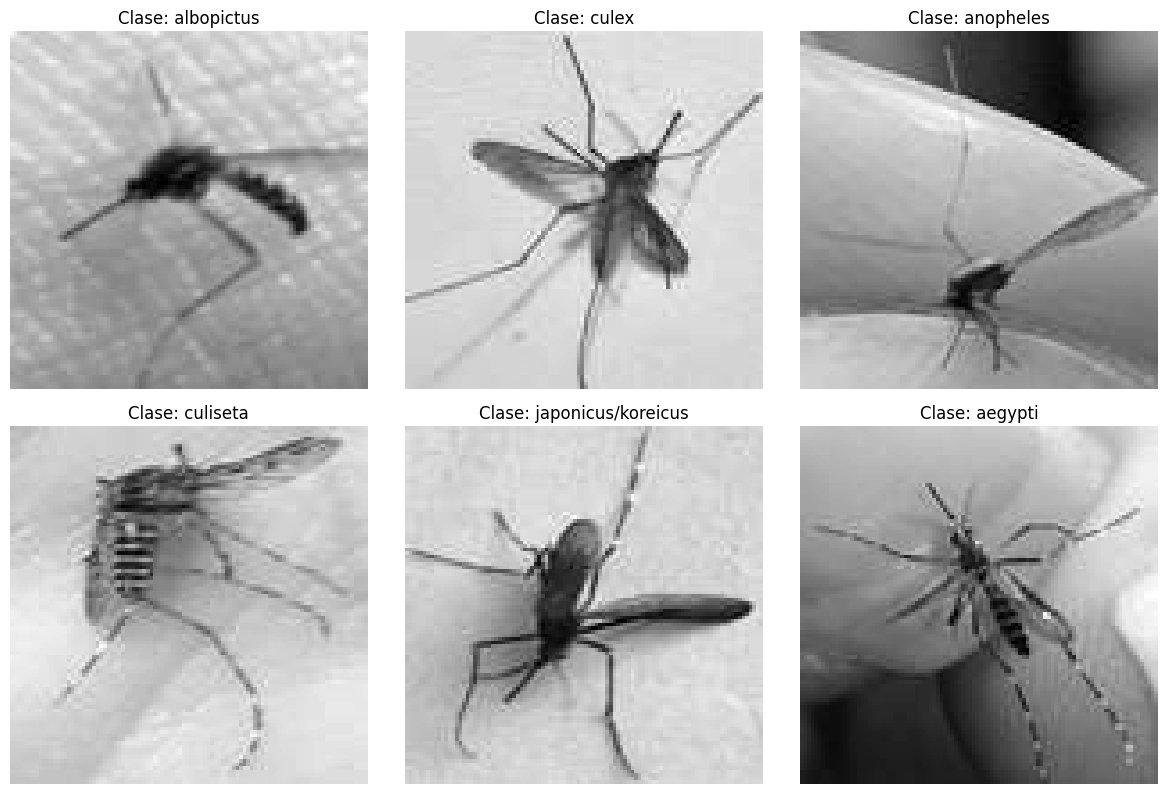

In [15]:
unique_classes = data['class_label'].unique()
num_rows = len(unique_classes) // 3 + 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, class_label in enumerate(unique_classes):
    class_data = data[data['class_label'] == class_label]
    first_image_name = class_data.iloc[0]['img_fName']
    image_path = os.path.join(output_folder, first_image_name)
    img = Image.open(image_path)
    
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Clase: {class_label}')
    axes[row, col].axis('off')

for i in range(len(unique_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [16]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

max_images = data['class_label'].value_counts().max()
data_balanced = pd.DataFrame(columns=['img_fName', 'class_label'])
data_balanced = pd.concat([data_balanced, data], ignore_index=True)
unique = data['class_label'].unique()

for class_label in tqdm(unique):
    class_count = sum(data['class_label'] == class_label)
    
    if class_count < max_images:
        num_new_images = max_images - class_count
        class_images = data[data['class_label'] == class_label]['img_fName']
        
        for i, original_image_name in enumerate(class_images):
            img = load_img(os.path.join(output_folder, original_image_name), color_mode='grayscale')
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                i += 1
                if i > num_new_images:
                    break
                
                new_img = array_to_img(batch[0], scale=False)
                new_image_name = f'new_image_{original_image_name.split(".")[0]}_{i}.jpeg'
                new_img.save(os.path.join(output_folder, new_image_name))
                
                new_data = pd.DataFrame({
                    'img_fName': [new_image_name],
                    'class_label': [class_label]
                })
                data_balanced = pd.concat([data_balanced, new_data], ignore_index=True)
                
            if i >= num_new_images:
                break

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:46<00:00, 27.72s/it]


In [17]:
data_balanced = shuffle(data_balanced)
print(data_balanced['class_label'].value_counts())

data_balanced.to_csv('data_balanced.csv', index=False)

albopictus            4612
anopheles             4612
aegypti               4612
culiseta              4612
culex                 4612
japonicus/koreicus    4612
Name: class_label, dtype: int64


In [19]:
# Extracción de características HOG y preparación del dataset
features = []
labels = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = os.path.join(output_folder, row.img_fName)
    image = Image.open(img_path)
    
    # Extracción de características HOG
    feature = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    
    features.append(feature)
    labels.append(row.class_label)

  0%|          | 0/10357 [00:00<?, ?it/s]


TypeError: hog() got an unexpected keyword argument 'multichannel'

In [ ]:
# Conversión de listas a arrays
features = np.array(features)
labels = np.array(labels)

In [ ]:
# Codificación de etiquetas
le = LabelEncoder()
labels_enc = le.fit_transform(labels)

In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels_enc, test_size=0.2, random_state=42)

#### Definición y entrenamiento del modelo SVM

In [ ]:
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 128)               3840128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 3848774 (14.68 MB)
Trainable params: 38487

#### Resultados del Modelo

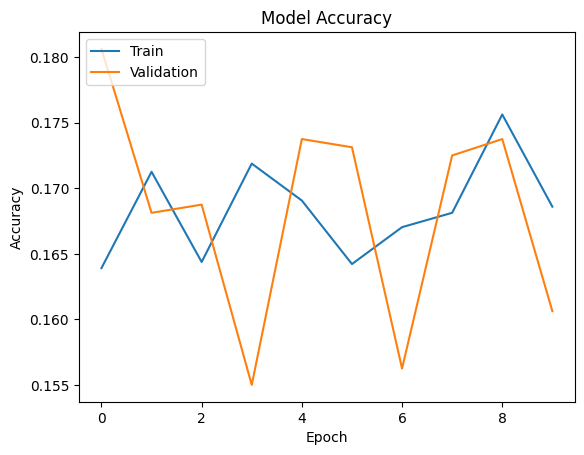

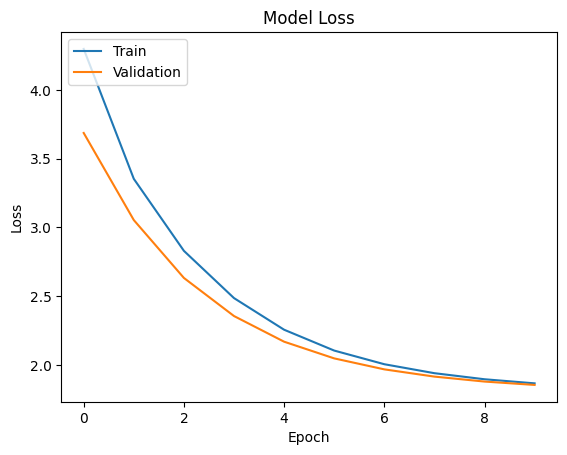

In [ ]:
# Evaluación del modelo
y_pred_train = clf.predict(X_train)
print("Accuracy on Train data: ", accuracy_score(y_train, y_pred_train))

y_pred_test = clf.predict(X_test)
print("Accuracy on Test data: ", accuracy_score(y_test, y_pred_test))

print("\nClassification Report:\n", classification_report(y_test, y_pred_test, target_names=le.classes_))

#### Validacion con imagen 

In [ ]:
# Función de predicción para una nueva imagen
def predict_mosquito_type_svm(clf, img_path):
    img = Image.open(img_path)
    img = color.rgb2gray(np.array(img))
    feature = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)

    prediction = clf.predict([feature])
    predicted_label = le.inverse_transform(prediction)[0]
    
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

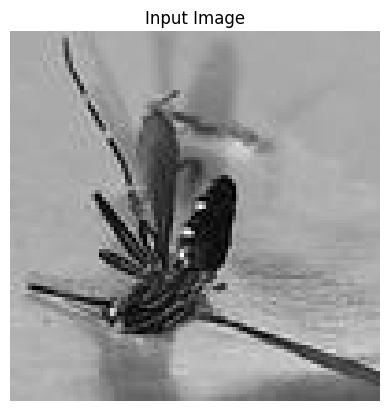

1/1 [==============================] - 0s 134ms/step
Prediction: japonicus/koreicus (16.78%)


'japonicus/koreicus'

In [ ]:
# Probando con una nueva imagen
predict_mosquito_type_svm(clf, "prueba.jpeg")